# Models

**In this notebook, we will proceed to compare models to find the best win probability model then build sub models to answer our research question: ** *Does the importance of a given event depend on the time left in the game?*

We try three different models in this notebook: **Logistic Regression, XGBoost, and RandomForests.**
The Logisitic Regression Model serves as our baseline model since it is most standard, whereas XGBoost and RandomForests offer more complex approaches through boosting and ensemble tree methods respectively. These second two models are especially useful for this project given that they provide variable importance charts; this will be important for our submodels and answering our research question. Besides model selection, we also had to consider **variable selection**. We had to strike a balance between including too many variables and inevitably overfitting the model and including too few and missing some important features. In a data set with fewer continuous quantitative predictors, we had to find a model which best handles binary variables having to do with the existence or absence of an event. 
<br>
<br>
**Summary of Findings:**
- The models all favored home and away score as most important variables
- The event related binary variables did not appear to have a significant impact on the prediction, i.e. the fact that there was a Defensive Rebound was always secondary to the score differential
- Upon introducing teams into the model through one hot encoding, the models each saw a large boost in accuracy. This suggests that the model was then able to determine the best teams in the league then essential take their record into account. 
- Introducing individual players into the models did not improve the models at all.

In [63]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
import seaborn.apionly as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
from matplotlib  import cm
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
%matplotlib inline
import warnings
warnings.filterwarnings(action='once')

In [64]:
# import scraped data
pbp = pd.read_csv("pbp2.csv")
pbp = pbp.iloc[:,1:]

In [65]:
pbp.head()

,time,awayteam,hometeam,event,isawayevent,awayscore,homescore,quarter,gameID,isAssist,...,isMade,isMissed,isTurnover,shotDistance,primary_player,awayRun,awayLead,minutesRemaining,points_on_play,AWAY_WIN
0,12:00.0,Boston,Cleveland,Start of 1st quarter,1,2,0,1,0,0,...,0,0,0,0,NaN,0,2,48.000000,0,0
1,12:00.0,Boston,Cleveland,Jump ball: K. Love vs. A. Horford (K. Irving g...,1,2,0,1,0,0,...,0,0,0,0,K. Love,0,2,48.000000,0,0
2,11:44.0,Boston,Cleveland,K. Irving makes 2-pt shot from 10 ft (assist b...,1,2,0,1,0,1,...,1,0,0,10,K. Irving,2,2,47.733333,2,0
3,11:27.0,Boston,Cleveland,D. Rose misses 2-pt shot from 1 ft (block by A...,0,2,0,1,0,0,...,0,1,0,1,D. Rose,2,2,47.450000,0,0
4,11:23.0,Boston,Cleveland,Defensive rebound by A. Horford,1,2,0,1,0,0,...,0,0,0,0,A. Horford,2,2,47.383333,0,0


In [66]:
# grab the relevant columns for model building
var = list(pbp.columns[4:])
var.remove('AWAY_WIN')
var.remove('primary_player')
var.remove('gameID')
var

['isawayevent',
 'awayscore',
 'homescore',
 'quarter',
 'isAssist',
 'isOffRebound',
 'isDefRebound',
 'is3ptShot',
 'is2ptShot',
 'isFT',
 'isMade',
 'isMissed',
 'isTurnover',
 'shotDistance',
 'awayRun',
 'awayLead',
 'minutesRemaining',
 'points_on_play']

## Logistic Regression

In [67]:
# Logistic Model without Players and Teams

msk = np.random.rand(len(pbp)) < 0.3
data_train = pbp[msk]
data_test = pbp[~msk]

logit_model = LogisticRegression()
logit_model.fit(data_train[var],data_train.AWAY_WIN)

print("Logistic Regression Win Probability Model Train Accuracy: ", logit_model.score(data_train[var], data_train.AWAY_WIN))
print("\nLogistic Regression Win Probability Model Test Accuracy: ", logit_model.score(data_test[var], data_test.AWAY_WIN))

Logistic Regression Win Probability Model Train Accuracy:  0.736287557975

Logistic Regression Win Probability Model Test Accuracy:  0.733881586048


**These accuracies are quite good considering we are predicting on a play by play level of detail. In a game where lead changes and runs are common, the model is able to predict with over 70% accuracy. Our hypothesis is that the other 30% relates to occasions where the losing team does especially well during parts of the game.**

In [68]:
# Logistic Model with One-Hot-Encoded Players

categorical_columns = ['primary_player']
hot_players = pd.get_dummies(pbp, columns=categorical_columns, drop_first=True)

var = list(hot_players.columns[4:])
var.remove('AWAY_WIN')

msk = np.random.rand(len(hot_players)) < 0.3
data_train = hot_players[msk]
data_test = hot_players[~msk]

logit_model = LogisticRegression()
logit_model.fit(data_train[var],data_train.AWAY_WIN)

print("Logistic Regression Win Probability Model Train Accuracy: ", logit_model.score(data_train[var], data_train.AWAY_WIN))
print("\nLogistic Regression Win Probability Model Test Accuracy: ", logit_model.score(data_test[var], data_test.AWAY_WIN))

Logistic Regression Win Probability Model Train Accuracy:  0.755847033056

Logistic Regression Win Probability Model Test Accuracy:  0.751255277565


In [70]:
# Logistic Model with One-Hot-Encoded Players & Teams

categorical_columns = ['hometeam', 'awayteam', 'primary_player']
hot_df = pd.get_dummies(pbp, columns=categorical_columns, drop_first=True)

var = list(hot_df.columns[2:])
var.remove('AWAY_WIN')

msk = np.random.rand(len(hot_df)) < 0.3
data_train = hot_df[msk]
data_test = hot_df[~msk]

logit_model_3 = LogisticRegression()
logit_model_3.fit(data_train[var],data_train.AWAY_WIN)

print("Logistic Regression Win Probability Model Train Accuracy: ", logit_model_3.score(data_train[var], data_train.AWAY_WIN))
print("\nLogistic Regression Win Probability Model Test Accuracy: ", logit_model_3.score(data_test[var], data_test.AWAY_WIN))

Logistic Regression Win Probability Model Train Accuracy:  0.822297365499

Logistic Regression Win Probability Model Test Accuracy:  0.818418157106


In [164]:
# Logistic Model with One-Hot-Encoded Teams

categorical_columns = ['awayteam', 'hometeam']
hot_teams = pd.get_dummies(pbp, columns=categorical_columns, drop_first=True)

var = list(hot_teams.columns[2:])
var.remove('AWAY_WIN')
var.remove('primary_player')
var.remove('gameID')

msk = np.random.rand(len(hot_teams)) < 0.3
data_train = hot_teams[msk]
data_test = hot_teams[~msk]

logit_model = LogisticRegression()
logit_model.fit(data_train[var],data_train.AWAY_WIN)

print("Logistic Regression Win Probability Model Train Accuracy: ", 100 * logit_model.score(data_train[var], data_train.AWAY_WIN))
print("\nLogistic Regression Win Probability Model Test Accuracy: ", 100 * logit_model.score(data_test[var], data_test.AWAY_WIN))

Logistic Regression Win Probability Model Train Accuracy:  81.8095166428

Logistic Regression Win Probability Model Test Accuracy:  81.7775758952


**These accuracies indicate that adding predictors for teams involved in each play significantly improves the accuracy of the model (0.818 on test set vs. 0.736), but adding predictors for individual players has a very limited impact. Therefore, moving forwards we include Teams in our model, but do not include Players. **

## XGBoost

In [73]:
#XGBoost Model with Teams

import xgboost as xgb
data_tot = xgb.DMatrix(hot_teams[var], label=hot_teams.AWAY_WIN)
dtrain = xgb.DMatrix(data_train[var], label=data_train.AWAY_WIN)
dtest = xgb.DMatrix(data_test[var], label=data_test.AWAY_WIN)
param = {'max_depth': 5, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
num_round = 10
evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist)

ypred = bst.predict(dtest)
predictions = [round(value) for value in ypred]
accuracy = accuracy_score(data_test.AWAY_WIN, predictions)
print("\nXGBoost Test Accuracy: %.2f%%" % (accuracy * 100.0))

ypred = bst.predict(dtrain)
predictions = [round(value) for value in ypred]
accuracy = accuracy_score(data_train.AWAY_WIN, predictions)
print("\nXGBoost Train Accuracy: %.2f%%" % (accuracy * 100.0))


[0]	eval-auc:0.848739	train-auc:0.846578
[1]	eval-auc:0.893248	train-auc:0.893422
[2]	eval-auc:0.913724	train-auc:0.914699
[3]	eval-auc:0.931774	train-auc:0.932465
[4]	eval-auc:0.946022	train-auc:0.947114
[5]	eval-auc:0.954845	train-auc:0.955812
[6]	eval-auc:0.965722	train-auc:0.966404
[7]	eval-auc:0.972348	train-auc:0.972978
[8]	eval-auc:0.980345	train-auc:0.98094
[9]	eval-auc:0.98589	train-auc:0.986595

XGBoost Test Accuracy: 93.57%

XGBoost Train Accuracy: 93.72%


In [74]:
#XGBoost Model without Teams

import xgboost as xgb
var = list(pbp.columns[4:])
var.remove('AWAY_WIN')
var.remove('primary_player')
var.remove('gameID')
data_tot = xgb.DMatrix(pbp[var], label=pbp.AWAY_WIN)
dtrain = xgb.DMatrix(data_train[var], label=data_train.AWAY_WIN)
dtest = xgb.DMatrix(data_test[var], label=data_test.AWAY_WIN)
param = {'max_depth': 5, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
num_round = 10
evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst_old = xgb.train(param, dtrain, num_round, evallist)

ypred = bst_old.predict(dtest)
predictions = [round(value) for value in ypred]
accuracy = accuracy_score(data_test.AWAY_WIN, predictions)
print("\nXGBoost Test Accuracy: %.2f%%" % (accuracy * 100.0))

ypred = bst_old.predict(dtrain)
predictions = [round(value) for value in ypred]
accuracy = accuracy_score(data_train.AWAY_WIN, predictions)
print("\nXGBoost Train Accuracy: %.2f%%" % (accuracy * 100.0))


[0]	eval-auc:0.815805	train-auc:0.814968
[1]	eval-auc:0.819252	train-auc:0.819206
[2]	eval-auc:0.82043	train-auc:0.820705
[3]	eval-auc:0.821244	train-auc:0.821696
[4]	eval-auc:0.82472	train-auc:0.828485
[5]	eval-auc:0.82648	train-auc:0.830801
[6]	eval-auc:0.828666	train-auc:0.834985
[7]	eval-auc:0.829653	train-auc:0.837132
[8]	eval-auc:0.831562	train-auc:0.840008
[9]	eval-auc:0.833433	train-auc:0.84366

XGBoost Test Accuracy: 74.63%

XGBoost Train Accuracy: 75.22%


**With XGBoost we see a larger jump with the teams included via one hot encoding. This raises some concern: is this model overfit? Perhaps with more time we could investigate this high accuracy.**

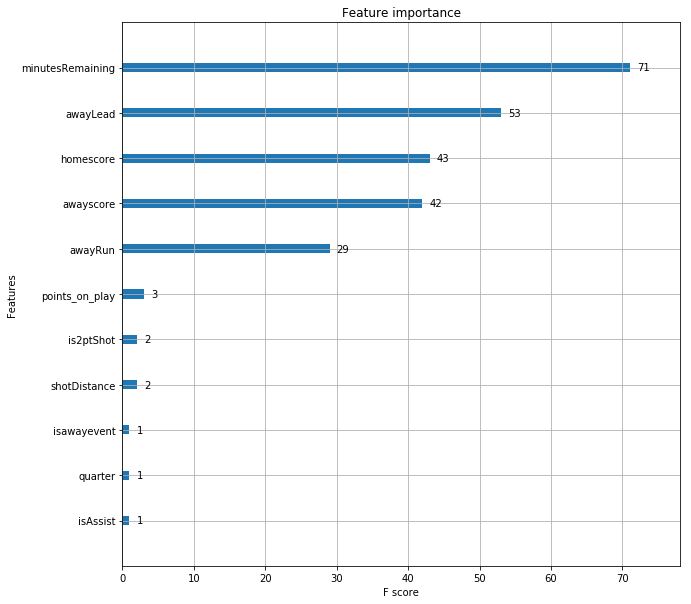

In [76]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

xgb.plot_importance(bst_old, ax=ax)

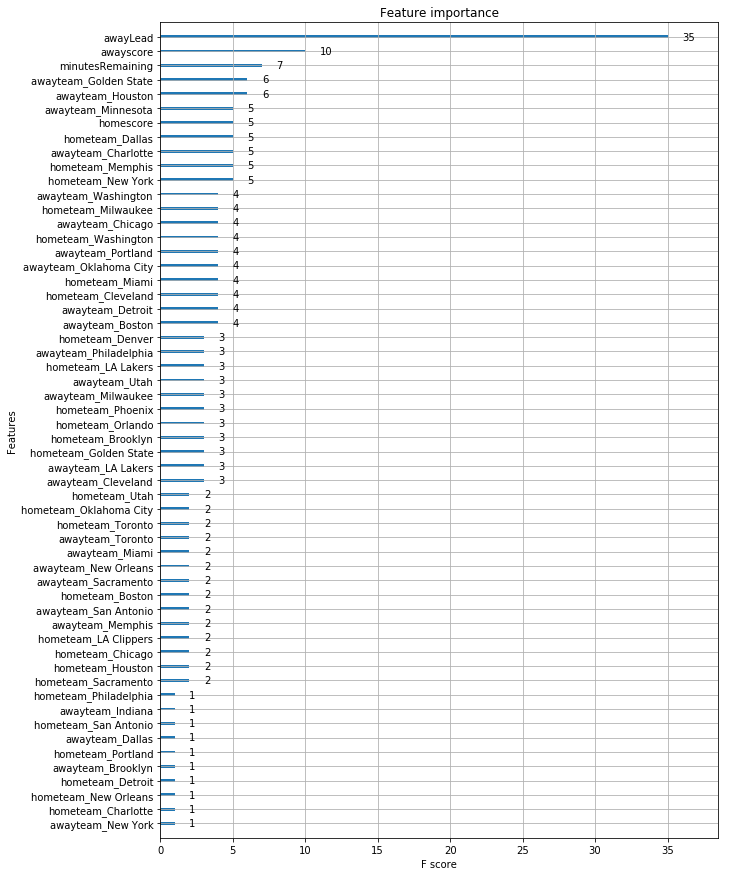

In [77]:
fig, ax = plt.subplots(1,1,figsize=(10,15))

xgb.plot_importance(bst, ax=ax)

**The variable importance plots for each model here show that score is taken to be most important in both cases.**

## Random Forests

In [168]:
# Random Forest Model without Team
from sklearn import ensemble

var = list(pbp.columns[4:])
var.remove('AWAY_WIN')
var.remove('primary_player')
var.remove('gameID')

msk = np.random.rand(len(pbp)) < 0.3
data_train = pbp[msk]
data_test = pbp[~msk]

rf = ensemble.RandomForestClassifier(max_features= 15, n_estimators= 15, oob_score=False)
rf.fit(data_train[var], data_train.AWAY_WIN)

In [169]:
print("\nRandom Forests Test Accuracy: %.3f%%" % (100 * rf.score(data_test[var],data_test.AWAY_WIN)))

print("\nRandom Forests Train Accuracy: %.3f%%" % (100 * rf.score(data_train[var],data_train.AWAY_WIN)))


Random Forests Test Accuracy: 84.499%

Random Forests Train Accuracy: 99.528%


**Our thought process here was to omit the teams since they raise concern with their high accuracy from XGBoost. When team is included, these models appear to commit to the better team early in the game, then in the sign of trouble, they immediately switch over to the winning team. Without team included, we see an 84.5% accuracy from random forest which is the best among the three.**